[2017-04-27 14:02:35,539] Making new env: Pong-v0


Continue from last saved episode
	ep 371: reward: -21.0 duration: 1014
	ep 372: reward: -21.0 duration: 1014
	ep 373: reward: -21.0 duration: 1014
	ep 374: reward: -21.0 duration: 1014
	ep 375: reward: -21.0 duration: 1014
	ep 376: reward: -21.0 duration: 5069
	ep 377: reward: -21.0 duration: 5069
	ep 378: reward: -21.0 duration: 5069
	ep 379: reward: -21.0 duration: 5069
	ep 380: reward: -21.0 duration: 5069
Model saved, mean reward is -21.0 last action prob is [ 0.75073123  0.24926871]


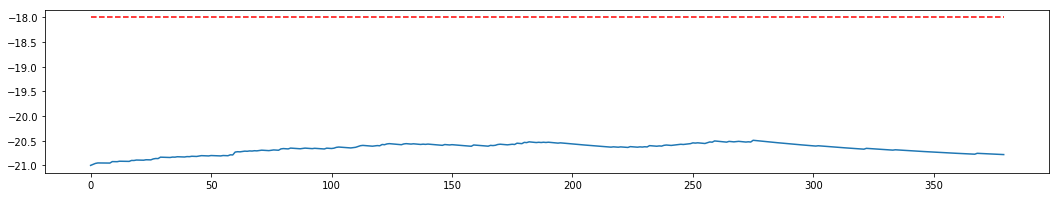

	ep 381: reward: -21.0 duration: 5243
	ep 382: reward: -21.0 duration: 5243
	ep 383: reward: -21.0 duration: 5243


In [ ]:
import numpy as np
import pandas as pd
import gym
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import random

# Initialize OpenAI for Pong
env = gym.make("Pong-v0")

# Hyper parameters for policy gradient model
global num_actions, discount, batch_size
num_actions = 2
discount = 0.99
save_every = 10
train_every = 5
max_episode = 20000
batch_size=300

# Hyper parameters for Network
learning_rate=0.0001
decay_=0.99
epsilon_=1e-6

# Initialize parameter for policy gradient model 
observation = env.reset()
image_old  = None
images, fake_labels, rewards_std, reward_hist, reward_runn = [], [], [], [], []
reward_episode = 0

# Build network
def Network(image_):
    
    conv_1 = tf.layers.conv2d(inputs=image_,
                                    filters=32,
                                    kernel_size=[11,11],
                                    strides = 2,
                                    padding="same",
                                    activation=tf.nn.relu,
                                    use_bias=False,
                                    kernel_initializer= tf.contrib.layers.xavier_initializer())
        
    pool1 = tf.layers.max_pooling2d(inputs=conv_1, 
                                                   pool_size=[2,2], 
                                                   strides=2)

    conv_2 = tf.layers.conv2d(inputs=pool1,
                                filters=48,
                                kernel_size=[8,8],
                                strides = 2,
                                padding="same",
                                activation=tf.nn.relu,
                                use_bias=False,
                                kernel_initializer= tf.contrib.layers.xavier_initializer())

    pool_2 = tf.layers.max_pooling2d(inputs=conv_2, 
                                                   pool_size=[2,2], 
                                                   strides=2)
    
    flatten = tf.contrib.layers.flatten(pool_2, scope='Flatten')
    
    FCL = tf.layers.dense(inputs=flatten, 
                                 units=256,
                                 use_bias=False,
                                 kernel_initializer= tf.contrib.layers.xavier_initializer(),
                                 activation=tf.nn.relu)
    
    logits = tf.layers.dense(inputs=FCL, 
                             units=num_actions, 
                             use_bias=False,
                             kernel_initializer= tf.contrib.layers.xavier_initializer(),
                             name='logits')
    
    action_probs = tf.nn.softmax(logits)
    
    return action_probs

# Get discounted reward and normalize it
def discount_norm(rew):
    
    mean, variance= tf.nn.moments(rew, [0])
    rew -= mean
    rew /= tf.sqrt(variance + 1e-6)
    
    return rew

# Process image by cropping and binarizing
def process_obs(obs):
    
    obs = obs[35:195]
    obs = obs[::2,::2,0]
    obs[obs == 144] = 0
    obs[obs == 109] = 0
    obs[obs != 0] = 1 
    
    return obs.astype(np.float)  

# Break down into batch jobs to reduce GPU/CPU load
def gen_batch_index(num_of_steps):
    
    batch_index = []
    start = 0
    for index in np.array(range(0,num_of_steps,batch_size)):
        end=index
        if end > 0:
            batch_index.append([start,end])
        start=index
    end = num_of_steps
    batch_index.append([start,end])
    
    return batch_index

def get_running_mean(reward_hist):
    
    running_mean=[]
    mean=-21
    for i in range(len(reward_hist)):
        mean = 0.99*mean + 0.01*reward_hist[i]
        running_mean.append(mean)
        
    return running_mean

# Build model
with tf.Graph().as_default() as g:
    
    with tf.device("/gpu:0"):
        image_ = tf.placeholder(dtype=tf.float32, shape=[None, 80,80,1],name="image")
        fake_label_ = tf.placeholder(dtype=tf.float32, shape=[None, num_actions],name="fake_label")
        reward_ = tf.placeholder(dtype=tf.float32, shape=[None,1], name="reward")
        
        discounted_epr = discount_norm(reward_) # Get policy gradient

        tf_aprob = Network(image_)
        loss = tf.nn.l2_loss(fake_label_-tf_aprob) # Define loss
        optimizer = tf.train.RMSPropOptimizer(learning_rate, decay=decay_, epsilon=epsilon_)
        grads = optimizer.compute_gradients(loss, var_list=tf.trainable_variables(), grad_loss=discounted_epr)
        train_op = optimizer.apply_gradients(grads)

# Main program
with g.as_default(), tf.Session() as sess:
    
    tf.global_variables_initializer().run()
#     writer = tf.summary.FileWriter('./graph/', graph=tf.get_default_graph())
    saver = tf.train.Saver(tf.global_variables())
    
    # Load from last session or start over
    try:
        episode_number = pickle.load(open('PG-Pong-ckpt-3-CNN/last-episode.p','rb'))
        saver.restore(sess, 'PG-Pong-ckpt-3-CNN\\Pong_PG.ckpt-'+str(episode_number))
        reward_hist = pickle.load(open('PG-Pong-ckpt-3-CNN/all_reward.p','rb'))
        print('Continue from last saved episode')
    except:
        print('Training from beginning')
        episode_number = 0
        
    # Starting playing
    while episode_number <= max_episode:
        
        image_proc = process_obs(observation)
        image_diff = image_proc - image_old if image_old is not None else np.zeros((80,80))
        image_old = image_proc
        
        # Uniformly pick an action
        feed_step = {image_: np.reshape(image_diff, (1,80,80,1))}
        aprob = sess.run(tf_aprob,feed_step) ; aprob = aprob[0,:]
        action = np.random.choice(num_actions, p=aprob)
        label = np.zeros_like(aprob) ; label[action] = 1

        # Input action to OpenAI and get feedback
        observation, reward, done, info = env.step(action+2)
        reward_episode += reward

        # Record for training
        images.append(image_diff); fake_labels.append(label); rewards_std.append(reward)

        # Training
        if done:
            
            if episode_number % train_every == 0:
                
                
                batch_index = gen_batch_index(len(images))
                for item in batch_index:
                    feed_episode = {image_: np.array(images[item[0]:item[1]]).reshape(-1, 80, 80, 1), 
                            fake_label_: np.array(fake_labels[item[0]:item[1]]).reshape(-1,num_actions), 
                            reward_: np.array(rewards_std[item[0]:item[1]]).reshape(-1,1)}
                    sess.run(train_op,feed_episode)
                    
                # Clear memory
                episode_duration = len(rewards_std)
                images, fake_labels, rewards_std = [], [], []
            
            # Bookkeeping
            reward_hist.append(reward_episode)
            reward_runn.append(reward_episode)
            episode_number += 1
            observation = env.reset()
            print('\tep {}: reward: {} duration: {}'.format(episode_number, reward_episode,episode_duration))
            reward_episode = 0
            
            # Save model
            if episode_number % save_every == 0:
                
                saver.save(sess, 'PG-Pong-ckpt-3-CNN/Pong_PG.ckpt', global_step=episode_number)
                pickle.dump(episode_number,open('PG-Pong-ckpt-3-CNN/last-episode.p','wb'))
                pickle.dump(reward_hist,open('PG-Pong-ckpt-3-CNN/all_reward.p','wb'))
                print('Model saved, mean reward is',np.mean(reward_runn),'last action prob is',aprob)
                
                plt.figure(figsize=(18,3))
                plt.plot([-18]*len(reward_hist),'r--')
                plt.plot(np.array(get_running_mean(reward_hist)))
                plt.show()
                
                reward_runn = []


G:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,center=False).mean()
G:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_var is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,center=False).var()


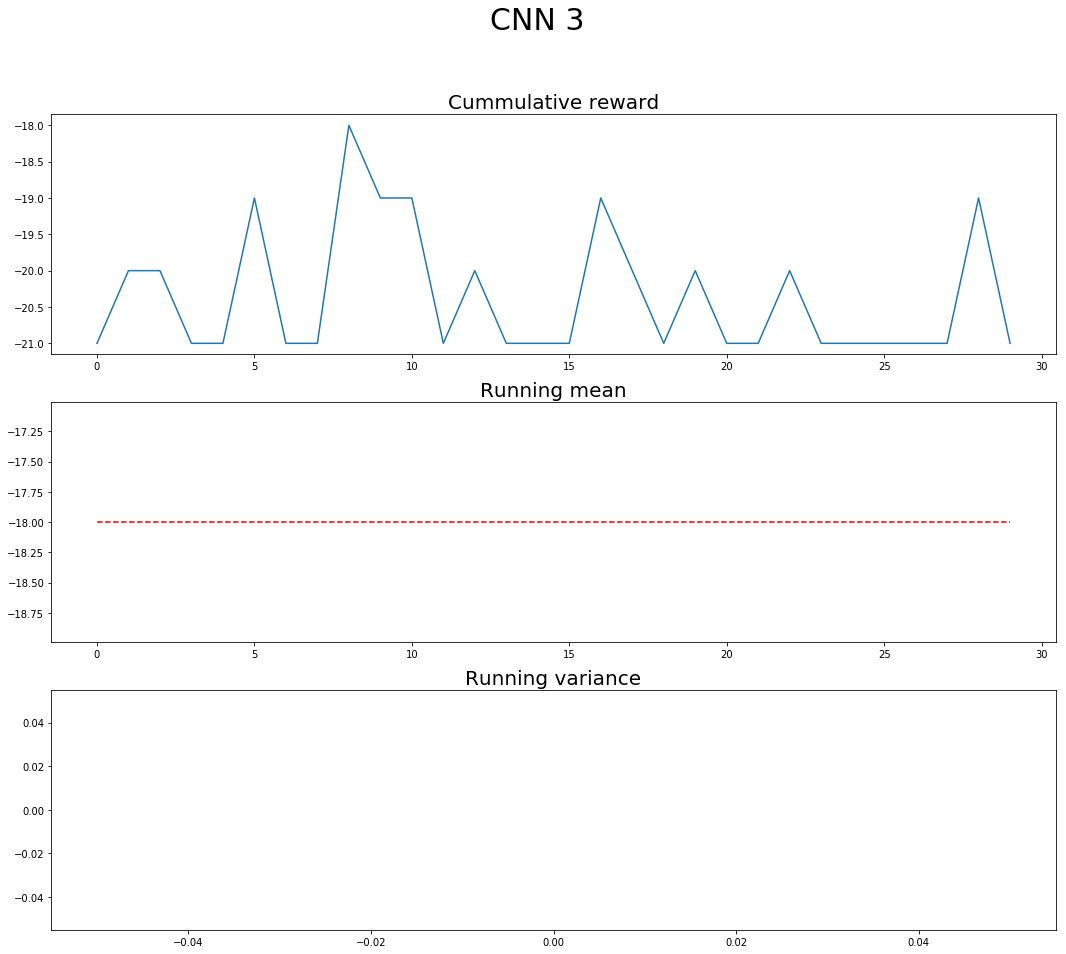

In [2]:
# Plotting
interval = 50

def get_mean_var(reward_hist):
    ts = pd.Series(reward_hist)
    return pd.rolling_mean(ts, interval), pd.rolling_var(ts, interval)

running_mean, running_var = get_mean_var(reward_hist)

fig,axe = plt.subplots(3,1,figsize=(18,15))
plt.suptitle('CNN 3',fontsize=30)
axe[0].plot(np.array(reward_hist))
axe[0].set_title('Cummulative reward',fontsize=20)
axe[1].plot(np.array(running_mean))
axe[1].plot([-18]*len(running_mean),'r--')
axe[1].set_title('Running mean',fontsize=20)
axe[2].plot(np.array(running_var))
axe[2].set_title('Running variance',fontsize=20)
plt.show()
fig.savefig('PG-Pong-ckpt-3-CNN/CNN3.jpg')